In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from nsdmd import optdmd
from nsdmd import utils
from nsdmd import nsdmd

In [2]:
t_step = 0.001
f1 = 4
t1 = np.arange(-500,1200)+500
f2 = 30
t2 = np.arange(-500,1200)+500
f3 = 17
t3 = np.arange(800,2500)+500
f4 = 30
t4 = np.arange(800,2500)+500

net1, F1_true, _ = utils.make_network(f1, len(t1), \
                    np.hstack([i*np.ones(50) for i in [1,2]]), \
                    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(0,30,10)]]),\
                    t_step, \
                    utils.create_decay(len(t1),1,400))
net2, F2_true, _  = utils.make_network(f2, len(t2), \
                    np.hstack([i*np.ones(50) for i in [1,2]]), \
                    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(-20,30,10)]]),\
                    t_step, \
                    utils.create_decay(len(t2),1,400))
net3, F3_true, _  = utils.make_network(f3, len(t3), \
                    np.hstack([i*np.ones(50) for i in [2,1]]), \
                    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(50,0,10)]]),\
                    t_step, \
                    utils.create_decay(len(t3),400,1))
gauss = scipy.stats.norm(800, 200).pdf(np.arange(1700))
gauss = gauss / np.max(gauss) + 0.3
net4, F4_true, _  = utils.make_network(f4, len(t4), \
                    np.hstack([i*np.ones(50) for i in [2,1]]), \
                    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(10,-40,10)]]),\
                    t_step, \
                    gauss*utils.create_decay(len(t4),400,1))
x = np.zeros((100,3000))
x[:,t1] += net1
x[:,t2] += net2
x[:,t3] += net3
x[:,t4] += net4
x = utils.add_noise(x, std=0.1)
t = np.arange(x.shape[1]) * t_step

Text(0, 0.5, 'Channel')

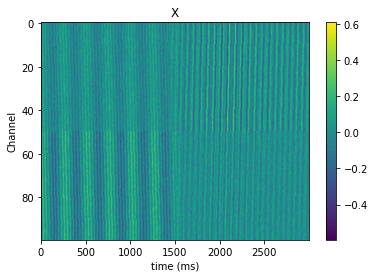

In [3]:
plt.imshow(x, aspect='auto')
plt.colorbar()
plt.title('X')
plt.xlabel('time (ms)')
plt.ylabel('Channel')

In [10]:
w_len = 500
stride = 100
rank = 4
freqs, phis, windows = nsdmd.opt_dmd_win(x, t, w_len, stride, rank)
x_extent = np.mean(t[windows], axis=1)

Text(0, 0.5, 'Freq (Hz)')

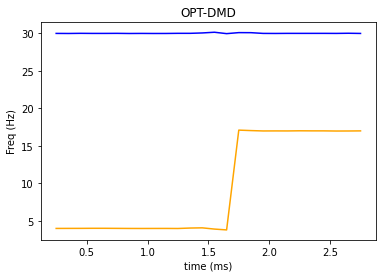

In [11]:
colors=['blue','orange','green','red']
for j, i in enumerate(range(0,rank,2)):
    plt.plot(x_extent, freqs[:,i], color=colors[j])
plt.title('OPT-DMD')
plt.xlabel('time (ms)')
plt.ylabel('Freq (Hz)')

In [12]:
soln = nsdmd.get_soln(freqs, phis, t, t[windows[:,0]])
soln_r = np.transpose(soln, (1,0,2,3)).reshape((-1, soln.shape[2], soln.shape[3]))

Text(0.5, 1.0, 'Similar Solutions')

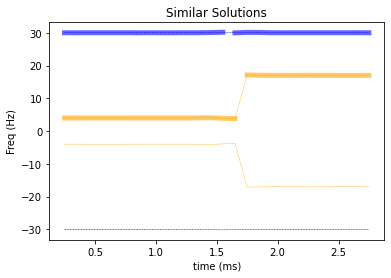

In [20]:
group_idx = nsdmd.group_by_similarity(freqs, phis, thresh_phi_amp=0.92)
    
sub_idx = []
for i, groups in enumerate(group_idx):
    for g in groups:
        sub_idx.append(np.random.choice(g) + i*(group_idx[-2][-1][-1]+1))
sub_idx = np.array(sub_idx)
sub_idx = sub_idx[np.sum(np.sum(soln_r[sub_idx], axis=2), axis=1)!=0] #In case trivial solutions get through

colors = ['blue', 'orange', 'green', 'red']
for i in range(len(group_idx)):
    plt.plot(x_extent, freqs[:,i], linestyle='dashed', color=colors[i//2], linewidth=0.5)
    for g in group_idx[i]:
        if(len(g)>1):
            plt.plot(x_extent[g], freqs[g,i], color=colors[i//2], linewidth=5, alpha=0.6)
        else:
            plt.scatter(x_extent[g], freqs[g,i], color=colors[i//2])
plt.xlabel('time (ms)')
plt.ylabel('Freq (Hz)')
plt.title('Similar Solutions')

In [21]:
B,f = nsdmd.exact_Bf(x, soln_r[sub_idx])

In [22]:
B.shape

(4, 4, 3000)

In [23]:
idx_all, total_error = nsdmd.exact_f_greedy(B,f,soln_r[sub_idx],x,30)

0/4
1/4
2/4
3/4


Text(0, 0.5, 'Cosine Distance')

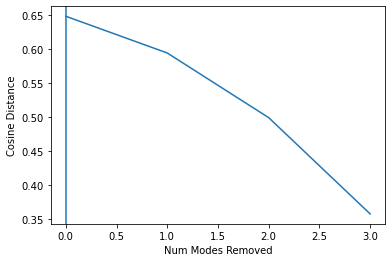

In [24]:
plt.plot(total_error)
plt.axvline(0)
plt.xlabel('Num Modes Removed')
plt.ylabel('Cosine Distance')

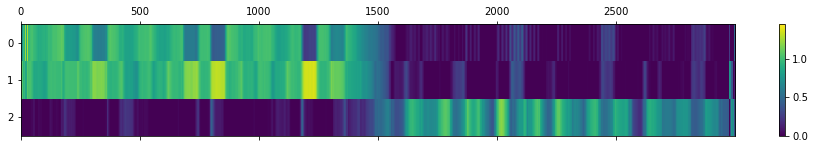

In [25]:
idx = idx_all[1]
f_hat = nsdmd.exact_f_from_Bf(np.array([b[idx] for b in B[idx]]),f[idx])
f_hat[:,30:-30] = utils.moving_average_dim(f_hat,61,1)
f_hat[f_hat<0] = 0
plt.matshow(f_hat, aspect='auto')
plt.colorbar()

/tmp/ipykernel_2173/3105158376.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + alpha)


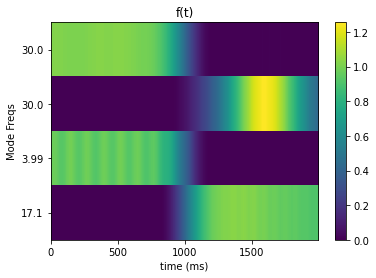

In [26]:
alpha = 0.1
beta = 0.1
lr_G = 0.01
maxiter = 100
N = 20

idx = sub_idx[idx_all[0]]
    
f_hat = nsdmd.grad_f(x, soln_r[idx], alpha, beta, N, lr_G, maxiter)
f_hat = nsdmd.grad_f_amp(f_hat, soln_r[idx], x)

alpha = [str(np.round(f,2)) for f in freqs.T.reshape((-1))[idx]]
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(f_hat[:,500:-500], aspect='auto')
fig.colorbar(cax)
ax.set_yticklabels([''] + alpha)
ax.xaxis.set_ticks_position('bottom')
plt.title('f(t)')
plt.xlabel('time (ms)')
plt.ylabel('Mode Freqs')
plt.savefig('recentImage')
plt.show()

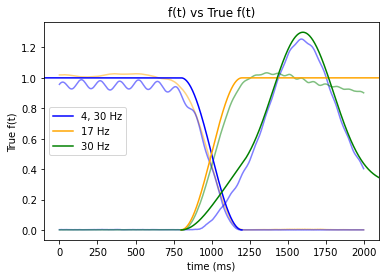

In [27]:
colors = ['orange', 'blue', 'blue', 'green', 'blue', 'green']
for i,f in enumerate(f_hat[:,500:-500]):
    plt.plot(f, color=colors[i], alpha=0.5)

    
plt.plot(t1-500, np.mean(F1_true, axis=0), color=colors[1], label=str(f1)+', '+str(f2)+' Hz')
plt.plot(t3-500, np.mean(F3_true, axis=0), color=colors[0], label=str(f3)+' Hz')
plt.plot(t4-500, np.mean(F4_true, axis=0), color=colors[3], label=str(f4)+' Hz')
plt.legend()
plt.xlim(-100,2100)
plt.xlabel('time (ms)')
plt.ylabel('True f(t)')
plt.title('f(t) vs True f(t)')
plt.savefig('recentImage')